In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import strip_punctuation
print((gensim.__version__))  # needed 3.8.3   -> pip install gensim==3.8.3
from sklearn.linear_model import LogisticRegression
import functions
import re
import numpy as np
np.random.seed(42)

4.2.0


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_year = 2020

In [5]:
df_all = pd.read_csv("outputs/df_sw_tok_low_punc_lemm_v7.csv").rename(columns = {'doi_x':'doi'})

lreg_w2v_avg = pickle.load(open('outputs/classifier/train_'+str(train_year)+'/'+'lreg_reg_w2v_avg_'+str(train_year)+'.sav', 'rb'))
model_w2v = gensim.models.Word2Vec.load("outputs/w2v/w2v_published_between_"+str(train_year-1) + " and "+ str(train_year)+".model")

lreg_bow =  pickle.load(open('outputs/classifier/train_'+str(train_year)+'/'+'lreg_reg_bow_'+str(train_year)+'.sav', 'rb'))
with open('outputs/classifier/train_'+str(train_year)+'/'+'tokens_bow_'+str(train_year)+'.data', 'rb') as filehandle:
    tokens_bow = pickle.load(filehandle)

# Test year citations - 2021

In [6]:
test_year = 2020
df_with_target = functions.add_target_opencitatins_marginal(target_year = test_year,df = df_all,target_col_name="target")

target
0    22317
1    17775
Name: count, dtype: int64


## FI BOW 

100%|██████████| 200/200 [04:02<00:00,  1.21s/it]


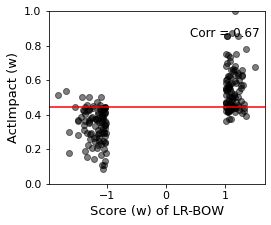

In [7]:
feature_importance_odds = functions.importance_lr_bow(tokens_bow,lreg_bow,n=100,odds_ratio = False)
words_lr_bow_odds = functions.word_score_info(list(feature_importance_odds.word.values), feature_importance_odds, df_with_target,df_all,add_dois = True)
significant_point = len(df_with_target[df_with_target["target"]==1])/len(df_with_target)

words_lr_bow_odds = words_lr_bow_odds[words_lr_bow_odds["cnt_of_articles_with_targ"]>5]
x1 = words_lr_bow_odds["score"]
y1 = words_lr_bow_odds["%_of_high_cit"]

%matplotlib inline
bottom = 0.05
height = 0.6
width = 0.5
left1, left2, left3, left4 = 0.06, 0.6, 2 - 0.5 - 0.5, 2 - 0.06 - 0.5
rectangle1 = [left1, bottom, width, height]
ax1 = plt.axes(rectangle1)
corr_value1 = round(np.corrcoef(x1.fillna(0).values, y1.fillna(0).values)[0, 1],2)
ax1.scatter(x1, y1, color = 'k', alpha=0.5)
ax1.axhline(y=significant_point, color='r', linestyle='-')
ax1.set_ylim([0, 1])
ax1.set_ylabel("ActImpact (w)",fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.set_xlabel("Score (w) of LR-BOW",fontsize = 13)
ax1.annotate("Corr = "+str(corr_value1), xy=(0.3, 1),xytext=(0.4, 0.85),fontsize = 12)
plt.savefig("outputs/corr/lr_bow.pdf", bbox_inches='tight')

## Importance of lreg w2v

In [8]:
#### words from articles for which have information about target (citations)
df_with_target['abstract_tokenized'] = functions.tokenized_column(df_with_target.reset_index()["abstract_cleaned"])
words_list_with_target = list(set([a for b in df_with_target.reset_index()['abstract_tokenized'] for a in b]))
print(len(words_list_with_target))

#### words of word2vec model dictionary trained on whole kaggle corpus
words = model_w2v.wv.key_to_index.keys()
we_dict = {word:model_w2v.wv[word] for word in words}
words_list_total = pd.DataFrame(we_dict.items())
print(len(words_list_total))


n=100
score_of_word_lr_avg_2 =  functions.score_of_word(model_w2v,lreg_w2v_avg).sort_values(by = ["score"], ascending=False).iloc[[*range(n),*range(-n,0)]]
words_lr_avg_w2v = functions.word_score_info(list(score_of_word_lr_avg_2.word.values), score_of_word_lr_avg_2, df_with_target,df_all,add_dois = True)
#words_lr_avg_w2v.to_csv('outputs/classifier/train_'+str(train_year)+'/'+'FI_LR_W2V_200_with_info.csv')
#functions.score_of_word(model_w2v,lreg_w2v_avg).sort_values(by = ["score"], ascending=False).to_csv('outputs/classifier/train_'+str(train_year)+'/'+'FI_LR_W2V.csv')

64754
82402


100%|██████████| 200/200 [04:06<00:00,  1.23s/it]


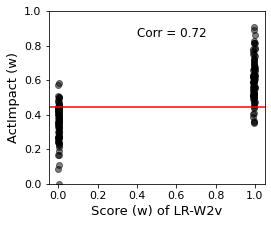

In [9]:
#words_lr_avg_w2v = pd.read_csv('outputs/classifier/train_'+str(train_year)+'/'+'FI_LR_W2V_200_with_info.csv')
words_lr_avg_w2v=words_lr_avg_w2v[words_lr_avg_w2v["cnt_of_articles_with_targ"]>5][["%_of_high_cit","score"]]

x1 = words_lr_avg_w2v["score"]
y1 = words_lr_avg_w2v["%_of_high_cit"]

bottom = 0.05
height = 0.6
width = 0.5

left1, left2, left3, left4 = 0.06, 0.6, 2 - 0.5 - 0.5, 2 - 0.06 - 0.5
rectangle1 = [left1, bottom, width, height]
ax1 = plt.axes(rectangle1)

corr_value1 = round(np.corrcoef(x1.fillna(0).values, y1.fillna(0).values)[0, 1],2)
ax1.scatter(x1, y1, color = 'k', alpha=0.5)
ax1.axhline(y=significant_point, color='r', linestyle='-')
ax1.set_ylim([0, 1])
ax1.set_ylabel("ActImpact (w)",fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.set_xlabel("Score (w) of LR-W2v",fontsize = 13)
ax1.annotate("Corr = "+str(corr_value1), xy=(0.3, 1),xytext=(0.4, 0.85),fontsize = 12)

plt.savefig("outputs/corr/lr_w2v.pdf", bbox_inches='tight')

# Test year citations - 2021

In [10]:
test_year = 2021
df_with_target = functions.add_target_opencitatins_marginal(target_year = test_year,df = df_all,target_col_name="target")

target
0    8576
1    4996
Name: count, dtype: int64


## LR-BOW

100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


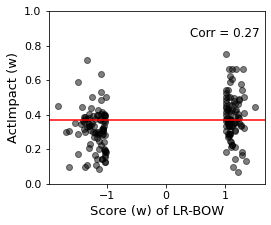

In [11]:
feature_importance_odds = functions.importance_lr_bow(tokens_bow,lreg_bow,n=100,odds_ratio = False)
words_lr_bow_odds = functions.word_score_info(list(feature_importance_odds.word.values), feature_importance_odds, df_with_target,df_all,add_dois = True)
significant_point = len(df_with_target[df_with_target["target"]==1])/len(df_with_target)

words_lr_bow_odds = words_lr_bow_odds[words_lr_bow_odds["cnt_of_articles_with_targ"]>5]
x1 = words_lr_bow_odds["score"]
y1 = words_lr_bow_odds["%_of_high_cit"]

%matplotlib inline
bottom = 0.05
height = 0.6
width = 0.5
left1, left2, left3, left4 = 0.06, 0.6, 2 - 0.5 - 0.5, 2 - 0.06 - 0.5
rectangle1 = [left1, bottom, width, height]
ax1 = plt.axes(rectangle1)
corr_value1 = round(np.corrcoef(x1.fillna(0).values, y1.fillna(0).values)[0, 1],2)
ax1.scatter(x1, y1, color = 'k', alpha=0.5)
ax1.axhline(y=significant_point, color='r', linestyle='-')
ax1.set_ylim([0, 1])
ax1.set_ylabel("ActImpact (w)",fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.set_xlabel("Score (w) of LR-BOW",fontsize = 13)
ax1.annotate("Corr = "+str(corr_value1), xy=(0.3, 1),xytext=(0.4, 0.85),fontsize = 12)
plt.savefig("outputs/corr/lr_bow_2021.pdf", bbox_inches='tight')

## LR-W2V

In [12]:
#### words from articles for which have information about target (citations)
df_with_target['abstract_tokenized'] = functions.tokenized_column(df_with_target.reset_index()["abstract_cleaned"])
words_list_with_target = list(set([a for b in df_with_target.reset_index()['abstract_tokenized'] for a in b]))
print(len(words_list_with_target))

#### words of word2vec model dictionary trained on whole kaggle corpus
words = model_w2v.wv.key_to_index.keys()
we_dict = {word:model_w2v.wv[word] for word in words}
words_list_total = pd.DataFrame(we_dict.items())
print(len(words_list_total))


n=100
score_of_word_lr_avg_2 =  functions.score_of_word(model_w2v,lreg_w2v_avg).sort_values(by = ["score"], ascending=False).iloc[[*range(n),*range(-n,0)]]
words_lr_avg_w2v = functions.word_score_info(list(score_of_word_lr_avg_2.word.values), score_of_word_lr_avg_2, df_with_target,df_all,add_dois = True)
#words_lr_avg_w2v.to_csv('outputs/classifier/train_'+str(train_year)+'/'+'FI_LR_W2V_200_with_info.csv')
#functions.score_of_word(model_w2v,lreg_w2v_avg).sort_values(by = ["score"], ascending=False).to_csv('outputs/classifier/train_'+str(train_year)+'/'+'FI_LR_W2V.csv')

43510
82402


100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


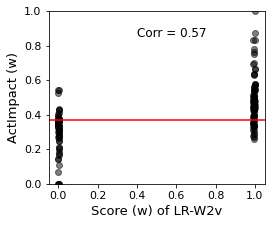

In [13]:
#words_lr_avg_w2v = pd.read_csv('outputs/classifier/train_'+str(train_year)+'/'+'FI_LR_W2V_200_with_info.csv')
words_lr_avg_w2v=words_lr_avg_w2v[words_lr_avg_w2v["cnt_of_articles_with_targ"]>5][["%_of_high_cit","score"]]

x1 = words_lr_avg_w2v["score"]
y1 = words_lr_avg_w2v["%_of_high_cit"]

bottom = 0.05
height = 0.6
width = 0.5

left1, left2, left3, left4 = 0.06, 0.6, 2 - 0.5 - 0.5, 2 - 0.06 - 0.5
rectangle1 = [left1, bottom, width, height]
ax1 = plt.axes(rectangle1)

corr_value1 = round(np.corrcoef(x1.fillna(0).values, y1.fillna(0).values)[0, 1],2)
ax1.scatter(x1, y1, color = 'k', alpha=0.5)
ax1.axhline(y=significant_point, color='r', linestyle='-')
ax1.set_ylim([0, 1])
ax1.set_ylabel("ActImpact (w)",fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.set_xlabel("Score (w) of LR-W2v",fontsize = 13)
ax1.annotate("Corr = "+str(corr_value1), xy=(0.3, 1),xytext=(0.4, 0.85),fontsize = 12)

plt.savefig("outputs/corr/lr_w2v_2021.pdf", bbox_inches='tight')